<a href="https://colab.research.google.com/github/ChanglinWu/DL/blob/main/CNN4_CIFAR_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch Convolutional Neural Network (CNN) With CIFAR-10 Color Image Dataset

In this example, we demonstrate how to train a CNN model (aka ConvNet)  to classify images from the CIFAR-10 dataset. With the nature of CNN can handle spatial data of images and video, the RGB-color images  of CIFAR-10 can be directly use as input to the model.

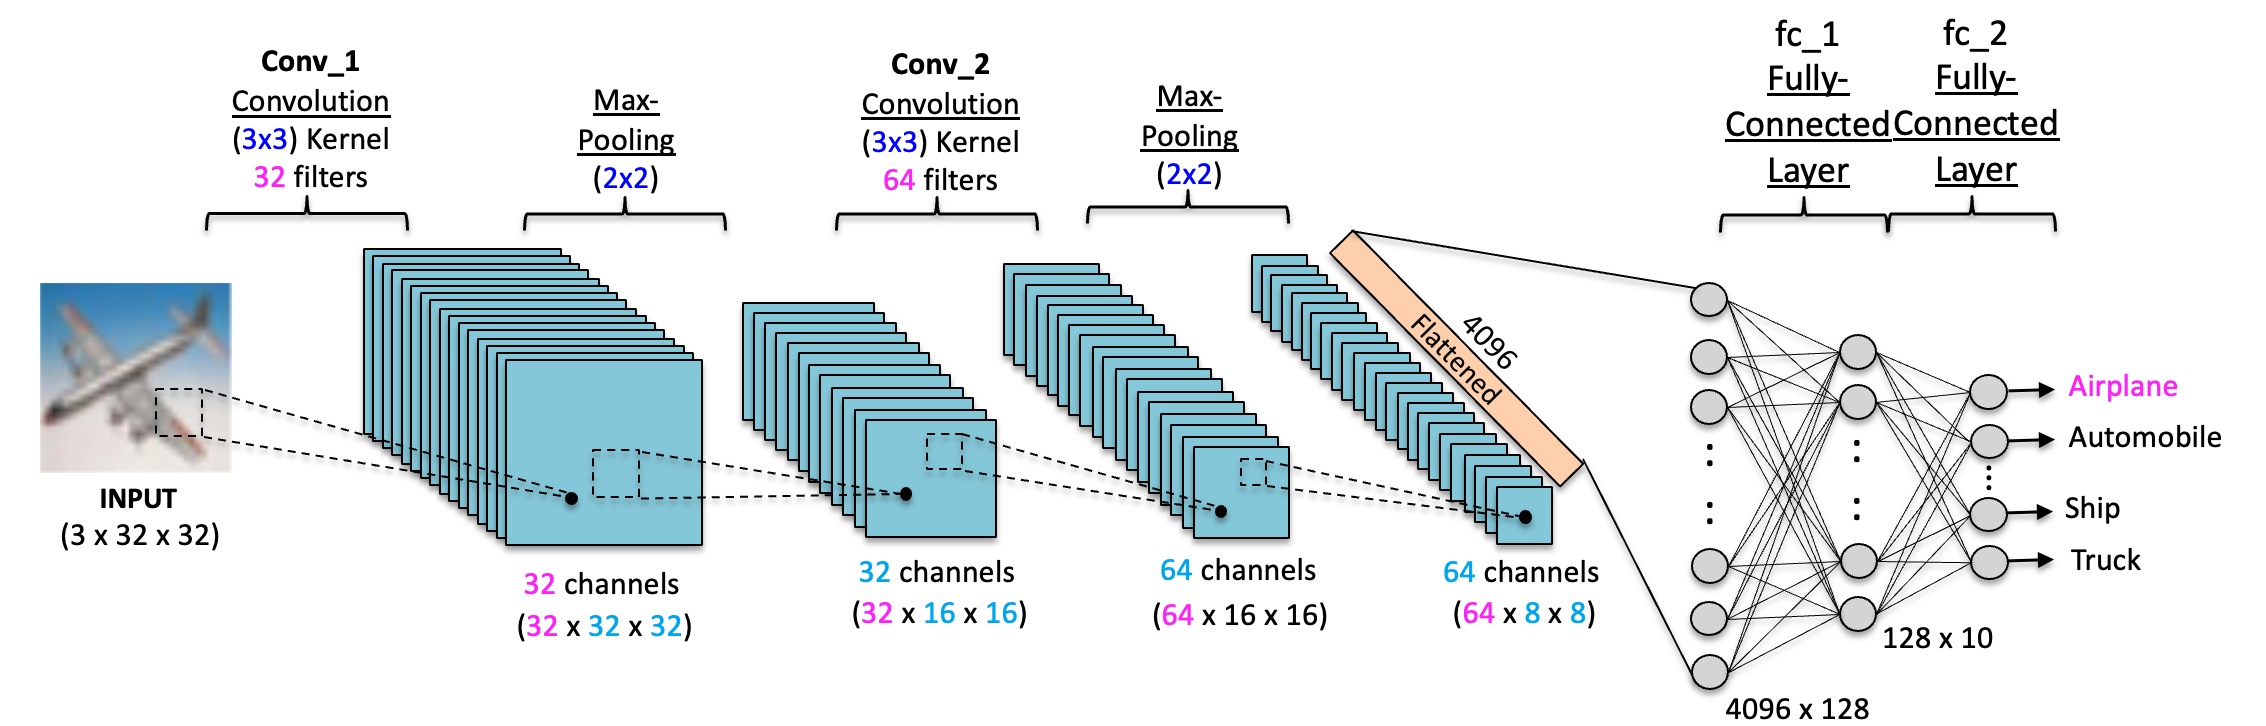

The CIFAR-10 dataset is a widely used collection of images that is commonly used to train machine learning and computer vision algorithms

- It consists of 60,000 32x32 color images in 10 different classes
- Each class contains 6,000 images, with 5,000 images for training and 1,000 images for testing
- The 10 different classes in the CIFAR-10 dataset represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks

The CIFAR-10 dataset can be split into training set, validation set, and test set in various ways. In this example, the way is to use 45,000 images for training, 5,000 images for validation, and 10,000 images for testing.

<!-- <img src='https://corochann.com/wp-content/uploads/2021/09/cifar10_plot.png'> -->


References:

- https://github.com/nestorojeda/CIFAR-10-CNN


In [ ]:
# Install the torchinfo package for showing the network architecture information
!pip install torchinfo -qqq

In [ ]:
# Import the necessary libraries for working with CIFART-10 dataset and PyTorch.
import torch
import torchvision
from torchvision import datasets,transforms
import torch.nn as nn
import torch.nn.functional as F
from torch import nn,optim,no_grad
from torch.utils.data import DataLoader
import torch.optim.lr_scheduler as lr_scheduler
from torchinfo import summary

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np
import pickle
import sys
import time

In [ ]:
# To configure the usage of a GPU (cuda) or MPS (Apple) if either of them is available
has_mps = torch.backends.mps.is_built()
device = "cuda" if torch.cuda.is_available() else "mps" if has_mps else "cpu"
print(f"Python versoin: {sys.version_info.major, sys.version_info.minor, sys.version_info.micro}")
print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

Python versoin: (3, 11, 11)
PyTorch version: 2.5.1+cu124
Device: cpu


In [ ]:
# Set seed for reproducibility
seed = 4016
torch.manual_seed(seed)

# Download CIFAR10 Dataset

This piece of code helps in downloading and managing the training and test data for a model. The training dataset used is called CIFAR-10 and it has 50,000 training samples. The test dataset is divided into two parts: a validation set and a test set, each with 5,000 samples. The data loaders help in providing batches of data from these datasets for the model to train on. The training data consists of batches of images, where each image is a 32 x 32 pixel color image. The corresponding labels indicate the correct class for each image, such as airplanes, cars, birds, cats, etc.


In [ ]:
# Define data transformations for the training and test sets
train_transform = transforms.Compose([
    #  transforms.RandomHorizontalFlip(p=0.5),
    #  transforms.RandomAffine(degrees=(-5, 5), translate=(0.1, 0.1), scale=(0.9, 1.1)),
     transforms.ToTensor(), # Convert images to tensors
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))]) # Normalize the image data

test_transform = transforms.Compose([
     transforms.ToTensor(), # Convert images to tensors
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))]) # Normalize the image data

# Create the CIFAR10dataset for the training set with 50,000 images
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)

# Create the CIFAR10 dataset for the test set with 10,000 images
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

# Split the original test set into a validation set with 5,000 samples and a test set with 5,000 samples
val_set, test_set = torch.utils.data.random_split(test_dataset, [5000, 5000])

# Define the data loaders for the training, validation, and test sets
train_loader = torch.utils.data.DataLoader(train_set, batch_size=256, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=256, shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=256, shuffle=False, num_workers=2)

# Define the classes for the CIFAR-10 dataset
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


100%|██████████| 170M/170M [00:16<00:00, 10.0MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## Visualize image for each class

The first step in a classification task is to take a look at the data, make sure it is loaded in correctly, then make any initial observations about patterns in that data.

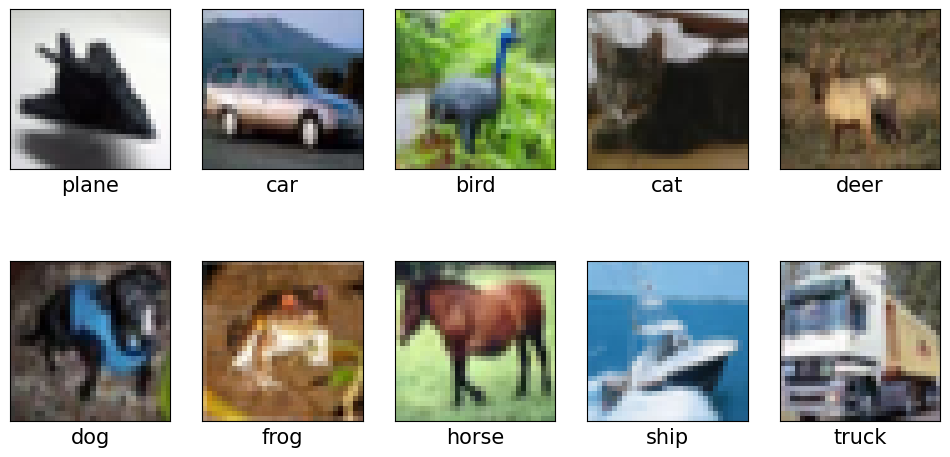

In [ ]:
# Visualize training image for each class
sample_images = [train_set.data[np.asarray(train_set.targets) == label][0] for label in range(10)]
# show images
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
i = 0
for row in axes:
  for axis in row:
    axis.set_xticks([])
    axis.set_yticks([])
    axis.set_xlabel(classes[i], fontsize=15)
    axis.imshow(sample_images[i])
    i += 1

## Define the CNN Architecture

The following code defines a class called CNN_Model which inherits from nn.Module. The network has 2 fully-connected layers:

- In the first line, we use the "Conv2d" module to implement a convolutional neural network. The first parameter, 3, indicates that the input image is colored and in RGB format. If it were a grayscale image, we would use 1 instead.

- The number 32 represents the initial output channels, and in the next Conv2d layer, we would use 32 as the input channels and 64 as the output channels.

- The third parameter in the first line is the kernel size, which determines the size of the filters used. The last parameter is for padding, which helps maintain the spatial dimensions of the input.

After each Conv2d layer, we apply an activation function, specifically the Rectified Linear Unit (ReLU). Following two Conv2d layers, we perform a max-pooling operation with a 2x2 size. The resulting values are then batch normalized to ensure stability and avoid internal covariate shift. These operations are repeated with additional layers to make the network deeper and reduce the size of the data. Finally, we flatten the layer to create a linear layer that maps the values to 10 outputs. The probability of each neuron in these 10 outputs determines the class to which a particular image belongs, with the highest probability indicating the predicted class.

In [ ]:
# Define the CNN Model

class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
    self.fc1 = nn.Linear(64 * 8 * 8, 128)
    self.fc2 = nn.Linear(128, 10)

  def forward(self, x):
    x = self.pool(torch.relu(self.conv1(x)))
    x = self.pool(torch.relu(self.conv2(x)))
    x = x.view(-1, 64 * 8 * 8) # Flatten the tensor
    x = torch.relu(self.fc1(x))
    x = self.fc2(x)
    return x

In [ ]:
model = CNN()

In [ ]:
summary(model=model, input_size=(1, 3, 32, 32), col_width=15,
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        row_settings=['var_names'], verbose=0)

Layer (type (var_name))                  Input Shape     Output Shape    Param #         Trainable
CNN (CNN)                                [1, 3, 32, 32]  [1, 10]         --              True
├─Conv2d (conv1)                         [1, 3, 32, 32]  [1, 32, 32, 32] 896             True
├─MaxPool2d (pool)                       [1, 32, 32, 32] [1, 32, 16, 16] --              --
├─Conv2d (conv2)                         [1, 32, 16, 16] [1, 64, 16, 16] 18,496          True
├─MaxPool2d (pool)                       [1, 64, 16, 16] [1, 64, 8, 8]   --              --
├─Linear (fc1)                           [1, 4096]       [1, 128]        524,416         True
├─Linear (fc2)                           [1, 128]        [1, 10]         1,290           True
Total params: 545,098
Trainable params: 545,098
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 6.18
Input size (MB): 0.01
Forward/backward pass size (MB): 0.39
Params size (MB): 2.18
Estimated Total Size (MB): 2.59

## Training the Network

The steps for training/learning from a batch of data are described in the comments below:

Clear the gradients of all optimized variables
Forward pass: compute predicted outputs by passing inputs to the model
Calculate the loss
Backward pass: compute gradient of the loss with respect to model parameters
Perform a single optimization step (parameter update)
Update average training loss
The following loop trains for 50 epochs; take a look at how the values for the training loss decrease over time. We want it to decrease while also avoiding overfitting the training data.

In [ ]:
# Create a Models folder to store the checkpoints
!mkdir Models

## Specify Loss Function and Optimizer
It's recommended that you use cross-entropy loss for classification. If you look at the documentation (linked above), you can see that PyTorch's cross entropy function applies a softmax funtion to the output layer and then calculates the log loss.

In [ ]:
criterion = nn.CrossEntropyLoss()  # Cross-Entropy Loss for multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer with learning rate 0.001


# optimizer = optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
# optimizer = optim.SGD(model.parameters(), lr=0.01)

# Specify Learning Rate Scheduler
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True, min_lr=0)

In [ ]:
EPOCHS = 40

loss_hist, acc_hist = [], []
loss_hist_val, acc_hist_val = [], []

model.to(device)

print("Training was started.\n")

for epoch in range(1,EPOCHS+1):
  time_ckpt=time.time()
  print("EPOCH:",epoch,end=" ")
  running_loss = 0.0
  correct = 0
  for data in train_loader:
    batch, labels = data
    batch, labels = batch.to(device), labels.to(device)

    optimizer.zero_grad()
    outputs = model(batch)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    # compute training statistics
    _, predicted = torch.max(outputs, 1)
    correct += (predicted == labels).sum().item()
    running_loss += loss.item()

  avg_loss = running_loss / len(train_set)
  avg_acc = correct / len(train_set)
  loss_hist.append(avg_loss)
  acc_hist.append(avg_acc)

  # validation statistics
  model.eval()
  with torch.no_grad():
    loss_val = 0.0
    correct_val = 0
    for data in val_loader:
      batch, labels = data
      batch, labels = batch.to(device), labels.to(device)
      outputs = model(batch)
      loss = criterion(outputs, labels)
      _, predicted = torch.max(outputs, 1)
      correct_val += (predicted == labels).sum().item()
      loss_val += loss.item()

    avg_loss_val = loss_val / len(val_set)
    avg_acc_val = correct_val / len(val_set)
    loss_hist_val.append(avg_loss_val)
    acc_hist_val.append(avg_acc_val)
  model.train()

  # scheduler.step(avg_loss_val)

  print("Training Loss: {:.3f}".format(avg_loss*100),end=" ")
  print("Val Loss: {:.3f}".format(avg_loss_val*100),end=" ")
  print("Train Accuracy: {:.2f}%".format(avg_acc*100),end=" ")
  print("Val Accuracy: {:.2f}%".format(avg_acc_val*100),end=" ")

  with open("Models/cnn_model_{}.pth".format(epoch),"wb") as f:
    model.eval()
    pickle.dump(model,f)
    model.train()

  print("Time: {:.2f}s".format(time.time()-time_ckpt),end=" \n")


Training was started.

EPOCH: 1 Training Loss: 0.565 Val Loss: 0.471 Train Accuracy: 48.67% Val Accuracy: 58.04% Time: 29.95s 
EPOCH: 2 Training Loss: 0.430 Val Loss: 0.415 Train Accuracy: 61.20% Val Accuracy: 63.58% Time: 28.60s 
EPOCH: 3 Training Loss: 0.378 Val Loss: 0.380 Train Accuracy: 66.32% Val Accuracy: 66.86% Time: 28.65s 
EPOCH: 4 Training Loss: 0.337 Val Loss: 0.355 Train Accuracy: 70.07% Val Accuracy: 68.96% Time: 28.77s 
EPOCH: 5 Training Loss: 0.306 Val Loss: 0.356 Train Accuracy: 72.82% Val Accuracy: 68.82% Time: 29.34s 
EPOCH: 6 Training Loss: 0.284 Val Loss: 0.343 Train Accuracy: 74.64% Val Accuracy: 70.74% Time: 29.85s 
EPOCH: 7 Training Loss: 0.258 Val Loss: 0.331 Train Accuracy: 77.22% Val Accuracy: 71.84% Time: 29.97s 
EPOCH: 8 Training Loss: 0.232 Val Loss: 0.338 Train Accuracy: 79.62% Val Accuracy: 71.12% Time: 29.34s 
EPOCH: 9 Training Loss: 0.211 Val Loss: 0.346 Train Accuracy: 81.39% Val Accuracy: 71.68% Time: 29.39s 
EPOCH: 10 Training Loss: 0.190 Val Loss: 

## Plotting Training Statistics

Loss is a function of the difference of the network output and the target values. We are minimizing the loss function during training so it should decrease over time. Accuracy is the classification accuracy for the test data.

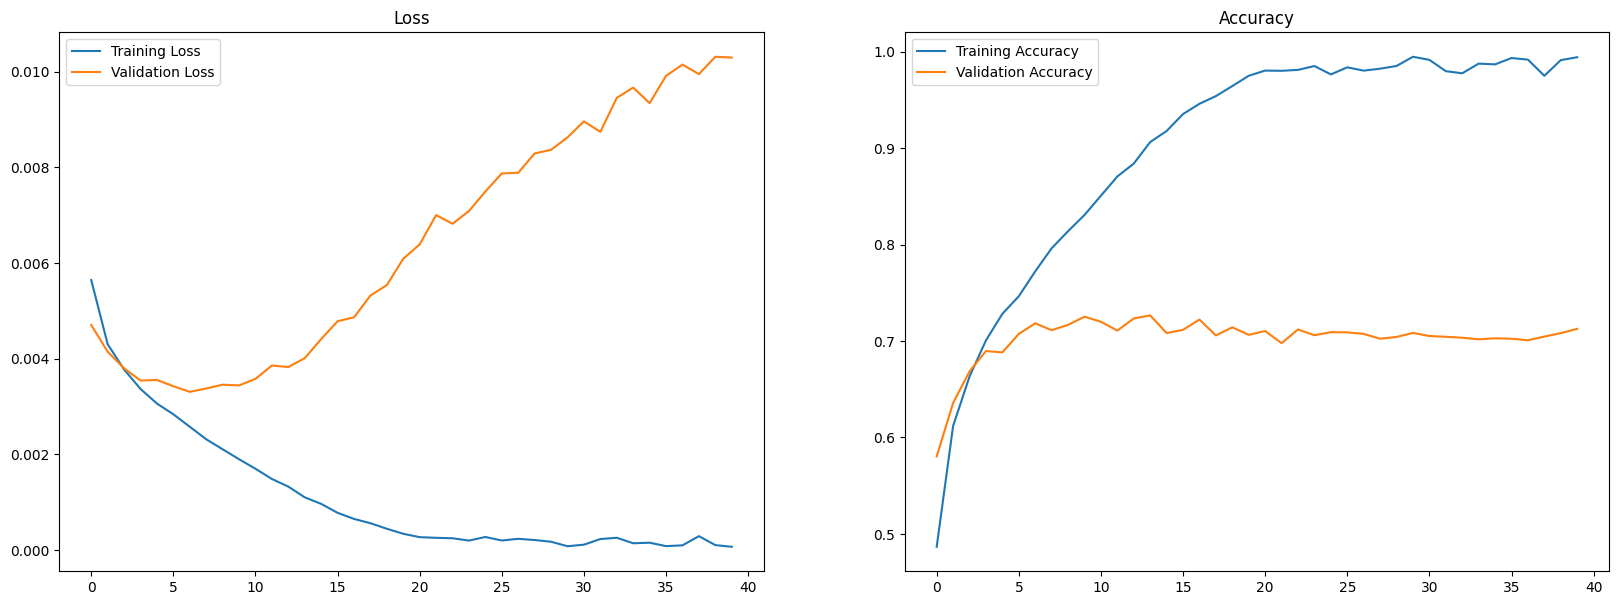

In [ ]:
plots=[(loss_hist,loss_hist_val),(acc_hist,acc_hist_val)]
plt_labels=[("Training Loss","Validation Loss"),("Training Accuracy","Validation Accuracy")]
plt_titles=["Loss","Accuracy"]
plt.figure(figsize=(20,7))
for i in range(0,2):
    ax=plt.subplot(1,2,i+1)
    ax.plot(plots[i][0],label=plt_labels[i][0])
    ax.plot(plots[i][1],label=plt_labels[i][1])
    ax.set_title(plt_titles[i])
    ax.legend()

## Save the trained model

In [ ]:
# from google.colab import files
# torch.save(model.state_dict(), 'checkpoint.pth')
# # download checkpoint file
# files.download('checkpoint.pth')
# model.load_state_dict(torch.load('checkpoint.pth'))

In [ ]:
# Selecting the best model
best_acc = max(acc_hist_val)
best_epoch = acc_hist_val.index(best_acc)+1

print("Best accuracy on validation set: {:.2f}%".format(best_acc*100))
print("Best epoch: {}".format(best_epoch))

with open(f"Models/cnn_model_{best_epoch}.pth","rb") as f:
    loaded_model=pickle.load(f)

Best accuracy on validation set: 72.66%
Best epoch: 14


# Test the Trained Network
Finally, we test our best model on previously unseen test data and evaluate it's performance. Testing on unseen data is a good way to check that our model generalizes well. It may also be useful to be granular in this analysis and take a look at how this model performs on each class as well as looking at its overall loss and accuracy.

In [ ]:
pred_vec = []
label_vec = []
correct = 0
test_loss = 0.0
avg_test_loss = 0.0
model.to(device)

with torch.no_grad():
    for data in test_loader:
        batch, labels = data
        batch, labels = batch.to(device), labels.to(device)
        outputs = model(batch)
        loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        test_loss += loss.item()
        pred_vec.extend(predicted.cpu().numpy())  # Convert tensor to numpy array
        label_vec.extend(labels.cpu().numpy())  # Convert tensor to numpy array

    avg_test_loss = test_loss / len(test_set)

pred_vec = np.array(pred_vec)
label_vec = np.array(label_vec)


# Display the Test Set Accuracy

In [ ]:
print(F"Test Loss: {avg_test_loss}")
print(F"Test Accuracy on the {len(test_set)} test images: {(100 * correct / len(test_set))}%")

Test Loss: 0.009885249972343444
Test Accuracy on the 5000 test images: 71.88%


# Display the Confusion Matrix

In [ ]:
# Create confusion matrix
from sklearn.metrics import confusion_matrix
confusion_mat = confusion_matrix(label_vec, pred_vec)
# Convert confusion matrix to pandas DataFrame
labels = np.unique(label_vec)
confusion_df = pd.DataFrame(confusion_mat, index=classes, columns=classes)
print("Confusion Matrix")
confusion_df

Confusion Matrix


,plane,car,bird,cat,deer,dog,frog,horse,ship,truck
plane,346,9,25,4,9,5,10,6,33,22
car,8,414,4,3,3,5,6,1,6,41
bird,27,3,307,25,45,33,33,22,5,7
cat,13,2,33,233,32,116,47,8,5,13
deer,8,5,35,24,360,24,42,23,2,4
dog,9,2,19,67,25,335,19,9,2,2
frog,5,2,19,17,20,14,426,4,2,4
horse,8,3,19,9,35,34,7,372,1,5
ship,27,23,5,8,5,7,9,1,403,22
truck,14,50,4,6,2,6,3,5,11,398


# Compute the Accuracy, F1-Score, Precision, Recall, Support

In [ ]:
# Create a report to show the f1-score, precision, recall
from sklearn.metrics import classification_report

report = pd.DataFrame.from_dict(classification_report(pred_vec,label_vec,output_dict=True)).T
report['Label']=[classes[int(x)] if x.isdigit() else " " for x in report.index]
report=report[['Label','f1-score','precision','recall','support']]
report

,Label,f1-score,precision,recall,support
0,plane,0.740899,0.737740,0.744086,465.0000
1,car,0.824701,0.843177,0.807018,513.0000
2,bird,0.628454,0.605523,0.653191,470.0000
3,cat,0.518931,0.464143,0.588384,396.0000
4,deer,0.677328,0.683112,0.671642,536.0000
5,dog,0.627341,0.685072,0.578584,579.0000
6,frog,0.764126,0.830409,0.707641,602.0000
7,horse,0.788136,0.754564,0.824834,451.0000
8,ship,0.822449,0.790196,0.857447,470.0000
9,truck,0.782694,0.797595,0.768340,518.0000


In the context of classification, 'support' refers to the number of instances or samples in a dataset that belong to a specific class. It represents the frequency or count of occurrences of each class in the dataset.

Support values help assess the reliability and generalizability of classification models, as they indicate the amount of data available for each class and the potential challenges associated with imbalanced datasets.

# Visualize Sample Test Results
This cell displays test images and their labels in this format: predicted (ground-truth). The text will be green for accurately classified examples and red for incorrect predictions.

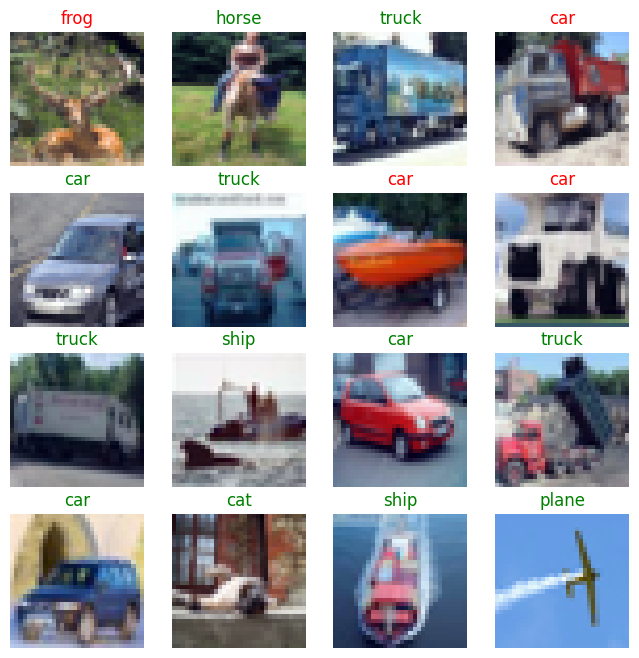

In [ ]:
# obtain one batch of test images
images, labels = next(iter(test_loader))
model.cpu()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)

# Create a 4x4 grid for displaying the images
fig, axes = plt.subplots(4, 4, figsize=(8, 8))

# Iterate over the images and display them in the grid
for idx, ax in enumerate(axes.flat):
  # Normalize the image tensor to [0, 1] range
  image = images[idx].permute(1, 2, 0)
  image = (image - image.min()) / (image.max() - image.min())
  ax.imshow(image)  # Display the image
  ax.axis('off')  # Hide the axes
  ax.set_title("{}".format(classes[preds[idx]]),
                 color=("green" if preds[idx]==labels[idx] else "red"))  # Add title to the image
plt.show()

#Display 50 Predicted Images
We iterate through 50 images and plot them with their corresponding label. We will color the label in blue if our model guessed correct and in red if it failed to predict that class.

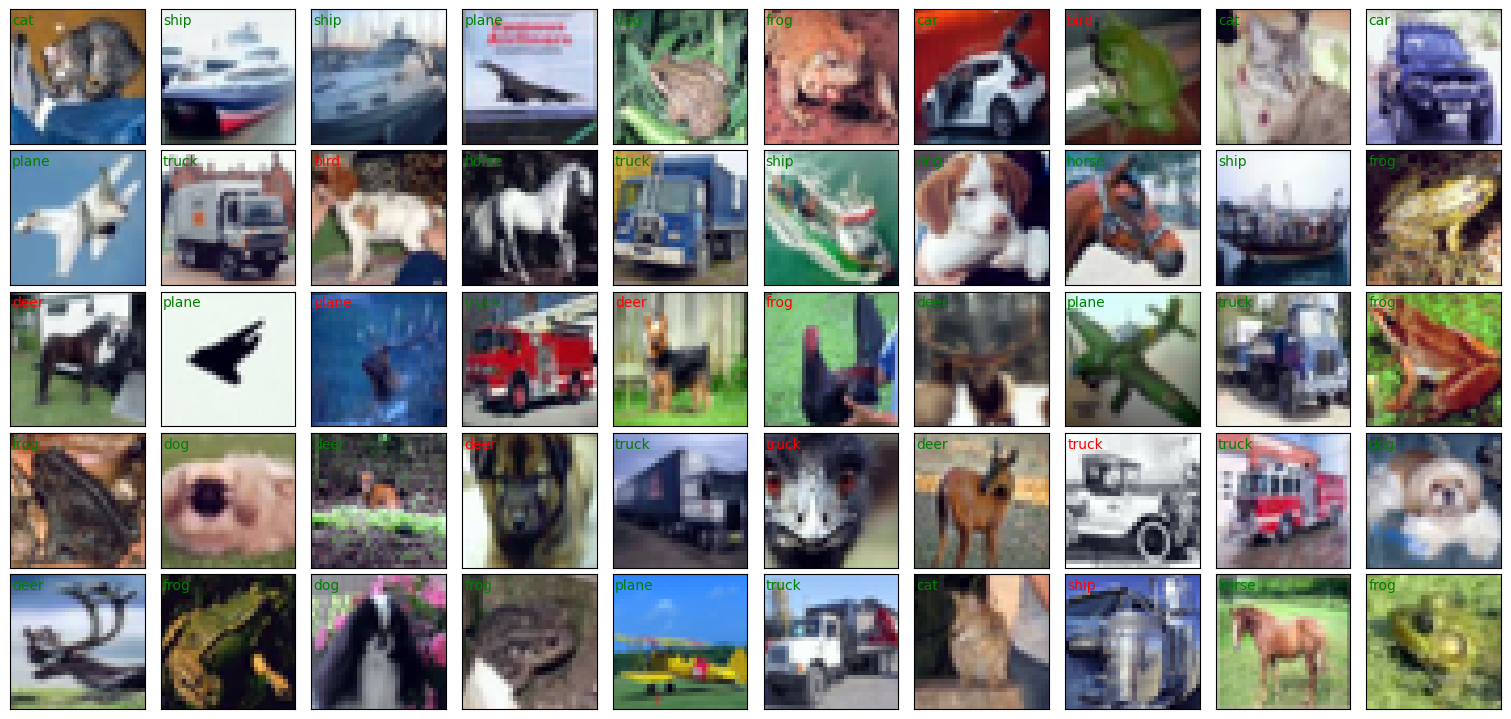

In [ ]:
# Define the loader for all test data
test_set_all = torchvision.datasets.CIFAR10(root='./data', train=False, download=False, transform=test_transform)
test_loader_all = torch.utils.data.DataLoader(test_set_all, batch_size=128, shuffle=False, num_workers=2)


# obtain one batch of test images
dataiter = iter(test_loader_all)
images, labels = next(iter(test_loader_all))
model.cpu()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)


fig = plt.figure(figsize=(15, 7))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for idx in range(50):
    # Normalize the image tensor to [0, 1] range
    image = images[idx].permute(1, 2, 0)
    image = (image - image.min()) / (image.max() - image.min())
    ax = fig.add_subplot(5, 10, idx + 1, xticks=[], yticks=[])
    ax.imshow(image, interpolation='nearest')

    if preds[idx]==labels[idx]:
      ax.text(0, 3, str(classes[preds[idx].item()]), color='green')
    else:
      ax.text(0, 3, str(classes[preds[idx].item()]), color='red')

plt.show()


## Visualize wrongly classified image for each class

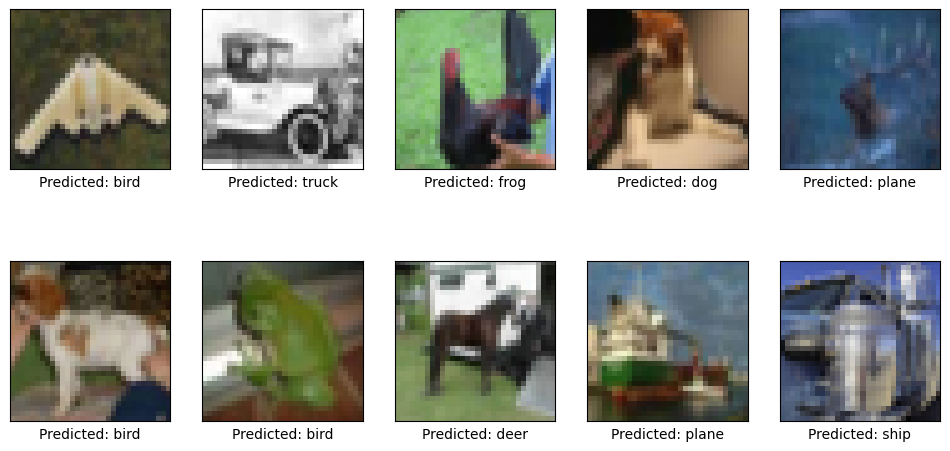

In [ ]:
# Visualize wrongly classified image for each class
pred_vec_all = []
correct = 0
test_loss = 0.0

model.to(device)

with torch.no_grad():
    for data in test_loader_all:
        batch, labels = data
        batch, labels = batch.to(device), labels.to(device)
        outputs = model(batch)
        test_loss=criterion(outputs, labels)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        pred_vec_all.append(predicted)
    pred_vec_all = torch.cat(pred_vec_all)

pred_vec_all = pred_vec_all.cpu().numpy()
ground_truths = np.asarray(test_set_all.targets)
incorrect_mask = pred_vec_all != ground_truths
incorrect_images = [test_set_all.data[(ground_truths == label) & incorrect_mask][0] for label in range(10)]
pred_results_all = [pred_vec_all[(ground_truths == label) & incorrect_mask][0] for label in range(10)]

# show images
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
i = 0
for row in axes:
  for axis in row:
    axis.set_xticks([])
    axis.set_yticks([])
    axis.set_xlabel("Predicted: %s" % classes[pred_results_all[i]], fontsize=10)
    axis.imshow(incorrect_images[i], cmap='gray')
    i += 1